Epoch 1/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6353 - val_loss: 0.1715
Epoch 2/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 0.1373 - val_loss: 0.1386
Epoch 3/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 0.1175 - val_loss: 0.1360
Epoch 4/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 0.1160 - val_loss: 0.1358
Epoch 5/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.1159 - val_loss: 0.1358
Epoch 6/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 0.1159 - val_loss: 0.1358
Epoch 7/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 0.1159 - val_loss: 0.1359
Epoch 8/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 0.1159 - val_loss: 0.1358
Epoch 9/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.1159 - val_loss: 0.1358
Epoch 10/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 0.1159 - val_loss: 0.1358
Epoch 11/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 0.1159 - val_loss: 0.1358
Epoch 12/100
285/285 

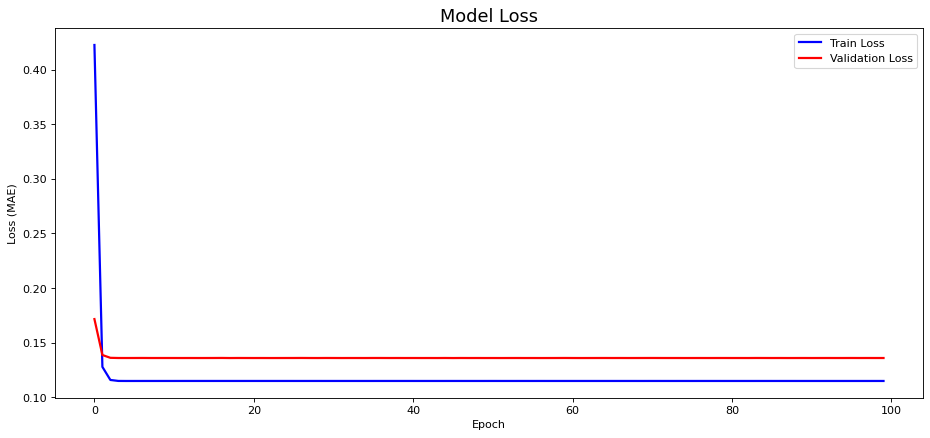

Model and scaler saved successfully!


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# Set random seeds for reproducibility
np.random.seed(10)
import tensorflow as tf
tf.random.set_seed(10)

# Load the dataset
filename = "/Users/amoggha/anomaly-detection-website/backend/normall.csv"  # Replace with the path to your dataset
merged_data = pd.read_csv(filename)

# Split into training and testing sets
train = merged_data.iloc[:3000]  # First 3000 rows for training
test = merged_data.iloc[3001:4500]  # Next 1500 rows for testing

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)

# Save the scaler for later use
joblib.dump(scaler, "scaler-data")

# Reshape the data for LSTM input (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the autoencoder model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False, kernel_regularizer=regularizers.l2(0.01))(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

# Create and compile the model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')

# Train the model
nb_epochs = 100
batch_size = 10
history = model.fit(
    X_train, X_train,
    epochs=nb_epochs,
    batch_size=batch_size,
    validation_split=0.05
)

# Plot the training and validation loss
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(history.history['loss'], 'b', label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], 'r', label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=16)
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Save the trained model
model.save("autoencoder_model.keras")

print("Model and scaler saved successfully!")